# Clasificación de Células Sanguíneas - Marcelo Rojas, Augustin Crepin

En el proceso de diagnóstico de enfermedades, el estudio de la cantidad de células sanguíneas juega un papel importante para determinar factores que explican una enfermedad. En esta tarea, la idea es implementar el modelo de deep-learning más efectivo posible para clasificar células sanguíneas. Las clases de células sanguíneas son: [Eosinophil, Lymphocyte, Monocyte, Neutrophil]


In [ ]:
#Instalamos el paquete gdown para poder descargar el dataset desde el gdrive
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Descargamos el dataset
import gdown
output = 'blood.zip'
gdown.download(id='1CUQjT45tJmqNv_p2HcDkr4Z-IDQEbRg3', output=output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1CUQjT45tJmqNv_p2HcDkr4Z-IDQEbRg3
To: /content/blood.zip
100%|██████████| 105M/105M [00:00<00:00, 299MB/s] 


'blood.zip'

In [ ]:
# Descomprimimos el dataset
!unzip blood.zip

Se truncaron las últimas líneas 5000 del resultado de transmisión.
  inflating: images/TRAIN/MONOCYTE/_0_4446.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_4528.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_453.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_4560.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_4563.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_4650.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_4667.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_4715.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_4745.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_4762.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_4778.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_4791.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_4862.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_4872.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_4881.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_4884.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_4925.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_494.jpeg  
  inflating: images/TRAIN/MONOCYTE/

Implementa la mejor red neuronal posible. Tú decides si usas una red creada por ti mismo o si empleas transfer-learning. Entrena la red con los datos en la carpeta "TRAIN" y usa los datos en "VAL" como validación.

Para medir el performance final, realiza las inferencias sobre los datos del conjunto "TEST" y computa el accuracy sobre el conjunto de test. El accuracy es la proporción de imágenes para las cuales la predicción es correcta. IMPORTANTE: el accuracy de test se calcula una sola vez cuando hayas finalizado todos tus experimentos. Para tomar decisiones sobre el modelo y sus hiperparámetros solo puedes usar el conjunto de entrenamiento y validación.

Detalla todos los experimentos que hiciste y cómo llegaste a la mejor red neuronal reportada. Discute los resultados, comparando los distintos experimentos que tomaste en cuenta y responde a la pregunta: Porqué tu modelo final fue el mejor de todo lo que probaste?

IMPORTANTE: Evita el overfitting a toda costa. Un modelo con overfitting es aquel que durante el entrenamiento las curvas de loss/accuracy para datos de entrenamiento y validación se separan considerablemente. 

Éxitos!

# Codigo

## Paquetes

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
import time
import os
import copy
from torchvision.io import read_image
from PIL import Image


## Clase Blood para los dataset

In [ ]:
class Blood(torch.utils.data.Dataset):
  def __init__(self, root, split, transform):
    self.root = root
    self.split = split
    self.transform = transform
    self.class2idx = dict()

    self.class2idx['EOSINOPHIL'] = 0
    self.class2idx['LYMPHOCYTE'] = 1
    self.class2idx['MONOCYTE'] = 2
    self.class2idx['NEUTROPHIL'] = 3

    self.classes = ['EOSINOPHIL','LYMPHOCYTE', 'MONOCYTE','NEUTROPHIL']

    lines=[]
    #to get files name
    for root, dirs, files in os.walk(f'images/{self.split}', topdown=False):
      for name in files:
        lines.append(os.path.join(root,name))
      for name in dirs:
        lines.append(os.path.join(root,name))

    self.images = []
    self.labels = []
    self.split = []

    for line in lines:
      line = line.strip()
      output = line.split(os.sep)
      if len(output)==4 : #remove useless data "creating"
        self.images.append(output[3]) 
        self.labels.append(output[2])
        self.split.append(output[1])
    print(len(self.split))
    print(f'images/{split}')
    
  def __len__(self):
    return len(self.images)
  
  def __getitem__(self, idx):
    image_path = os.path.join(self.root, self.split[idx], self.labels[idx], self.images[idx])
    image = Image.open(image_path)
    label = self.class2idx[self.labels[idx]]
    im = image.convert('RGB')

    if self.transform:
      image = self.transform(im)
      
                                                      
    return image, label

dataset = Blood(root='images/', split='TRAIN',
                                                transform=transforms.Compose([
                                                    transforms.RandomResizedCrop(224),
                                                    transforms. ToTensor(),
                                                    transforms.Normalize((0.5,),(0.5,))
                                                    
                                                ]))


9957
images/TRAIN


## Creación de datasets

9957
images/TRAIN
71
images/VAL
2487
images/TEST
(tensor([[[1.2899, 1.2728, 1.2385,  ..., 1.5810, 1.5468, 1.5468],
         [1.2899, 1.2728, 1.2385,  ..., 1.5810, 1.5468, 1.5468],
         [1.2557, 1.2557, 1.2214,  ..., 1.5810, 1.5468, 1.5468],
         ...,
         [1.3413, 1.3413, 1.3413,  ..., 1.0159, 1.0331, 1.0502],
         [1.3070, 1.3070, 1.3070,  ..., 1.0159, 1.0502, 1.0673],
         [1.2899, 1.2899, 1.3070,  ..., 1.0159, 1.0502, 1.0673]],

        [[1.1506, 1.1331, 1.0805,  ..., 1.8333, 1.8508, 1.8508],
         [1.1331, 1.1155, 1.0805,  ..., 1.8333, 1.8508, 1.8508],
         [1.0980, 1.0805, 1.0455,  ..., 1.8333, 1.8508, 1.8508],
         ...,
         [1.2731, 1.2731, 1.2906,  ..., 0.5028, 0.5378, 0.5378],
         [1.2031, 1.2031, 1.2381,  ..., 0.5203, 0.5553, 0.5553],
         [1.1856, 1.1856, 1.2206,  ..., 0.5203, 0.5553, 0.5553]],

        [[1.2282, 1.2108, 1.1759,  ..., 1.8034, 1.8383, 1.8383],
         [1.2282, 1.2108, 1.1759,  ..., 1.8034, 1.8383, 1.8383],
        

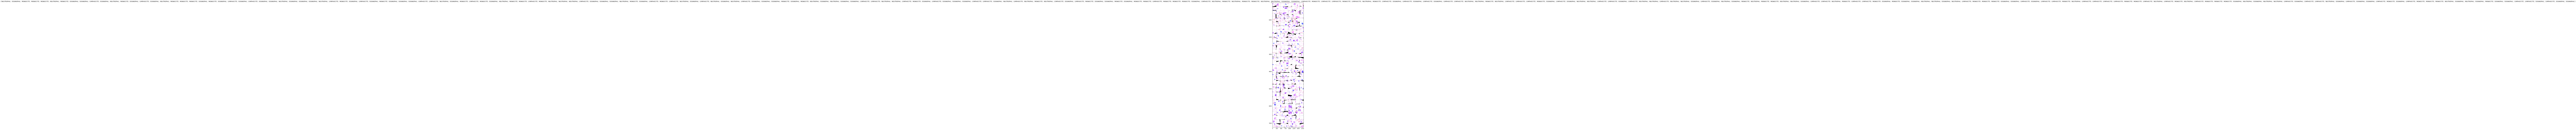

In [ ]:
train_dataset = Blood(root='images/', split='TRAIN',
                                                transform=transforms.Compose([
                                                    transforms.RandomResizedCrop(224),
                                                    transforms. ToTensor(),
                                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                        std=[0.229, 0.224, 0.225])
                                                ]))
val_dataset = Blood(root='images/', split = 'VAL',
                                              transform=transforms.Compose([
                                                    transforms.Resize(256),
                                                    transforms.CenterCrop(224),
                                                    transforms. ToTensor(),
                                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                         std=[0.229, 0.224, 0.225])
                                                ]))
test_dataset = Blood(root='images/', split = 'TEST',
                                              transform=transforms.Compose([
                                                    transforms.Resize(256),
                                                    transforms.CenterCrop(224),
                                                    transforms. ToTensor(),
                                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                         std=[0.229, 0.224, 0.225])
                                                ]))

print(train_dataset[9000])


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader= torch.utils.data.DataLoader(val_dataset, batch_size=256, shuffle=True)
test_loader= torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=True)

class_names = train_dataset.classes

def imshow(inp, title = None):
  plt.figure(figsize=(10,20))
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.5])
  std = np.array([0.5])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  
  if title is not None:
    plt.title(title)
  plt.pause(0.001)
  
inputs, classes = next(iter(train_loader))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

device = ('cuda' if torch.cuda.is_available() else 'cpu')


## Muestra de elementos del dataset

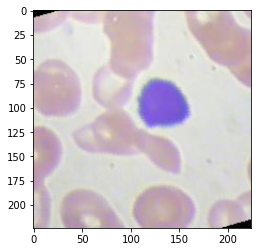

In [ ]:
img = test_dataset[3][0]
inp = img.numpy().transpose((1, 2, 0))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
inp = std * inp + mean
inp = np.clip(inp, 0, 1)
  
  
plt.figure()
plt.imshow(inp.squeeze())
plt.show()

## Funciones de entrenamiento

In [ ]:
def train_model(model, criterio, optimizer, scheduler, num_epochs = 25):
  since = time.time()
  
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  
  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs-1))
    print('-' * 10)
    
    #Train model
    model.train()
    
    running_loss = 0.0
    running_corrects = 0.0
    
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
          
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    
    epoch_loss = running_loss /len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)
    scheduler.step()
      
    print('Train Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
    
    #Validation 
    model.eval()
    running_loss = 0.0
    running_corrects = 0.0
    
    for inputs, labels in val_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
        
      with torch.set_grad_enabled(False):
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
          
      running_loss += loss.item() * inputs.size(0)
      running_corrects += torch.sum(preds == labels.data)
     
    epoch_loss = running_loss /len(val_dataset)
    epoch_acc = running_corrects.double() / len(val_dataset)
      
    print('Val Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
    
    if epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        
  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed % 60))
  print('Best val accucary: {:.4f}'.format(best_acc))

  model.load_state_dict(best_model_wts)
  return model

## Transfer learning con ResNet18

In [ ]:
model_ft = models.resnet18(pretrained=True)

print(model_ft)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
import torchsummary as ts

ts.summary(model_ft.to(device), input_size=(3,224,224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

### Fine tuning

In [ ]:
# Fine tuning
num_ft = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ft, 4)

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

In [ ]:
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
model_ft = train_model(model_ft, criterion, optimizer, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
Train Loss: 1.2760 Acc: 0.4064
Val Loss: 0.9772 Acc: 0.7042
Epoch 1/24
----------
Train Loss: 0.9059 Acc: 0.6429
Val Loss: 0.5501 Acc: 0.8451
Epoch 2/24
----------
Train Loss: 0.6767 Acc: 0.7280
Val Loss: 0.3954 Acc: 0.8873
Epoch 3/24
----------
Train Loss: 0.5522 Acc: 0.7775
Val Loss: 0.3172 Acc: 0.8732
Epoch 4/24
----------
Train Loss: 0.4850 Acc: 0.8029
Val Loss: 0.3330 Acc: 0.8732
Epoch 5/24
----------
Train Loss: 0.4317 Acc: 0.8269
Val Loss: 0.2894 Acc: 0.8451
Epoch 6/24
----------
Train Loss: 0.3917 Acc: 0.8442
Val Loss: 0.3196 Acc: 0.8592
Epoch 7/24
----------
Train Loss: 0.3817 Acc: 0.8476
Val Loss: 0.2886 Acc: 0.8873
Epoch 8/24
----------
Train Loss: 0.3743 Acc: 0.8514
Val Loss: 0.2838 Acc: 0.8873
Epoch 9/24
----------
Train Loss: 0.3719 Acc: 0.8513
Val Loss: 0.2844 Acc: 0.8873
Epoch 10/24
----------
Train Loss: 0.3720 Acc: 0.8486
Val Loss: 0.2866 Acc: 0.8873
Epoch 11/24
----------
Train Loss: 0.3732 Acc: 0.8452
Val Loss: 0.2833 Acc: 0.8873
Epoch 12/24
--

Rápida convergencia (best val acc alcanzado en la época 2)

### Freeze

In [ ]:
# Freeze 
model_fz = models.resnet18(pretrained=True)
for param in model_fz.parameters():
  param.requires_grad = False
  
num_ft = model_fz.fc.in_features
model_fz.fc = nn.Linear(num_ft,4)

model_fz = model_fz.to(device)
criterion = nn.CrossEntropyLoss()

optimizer_fz = torch.optim.SGD(model_fz.fc.parameters(), lr = 0.001, momentum=0.9)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_fz, step_size=7, gamma = 0.1)

model_fz = train_model(model_fz, criterion, optimizer_fz, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
Train Loss: 1.3671 Acc: 0.3246
Val Loss: 1.2666 Acc: 0.4507
Epoch 1/24
----------
Train Loss: 1.2380 Acc: 0.4553
Val Loss: 1.0693 Acc: 0.6479
Epoch 2/24
----------
Train Loss: 1.1646 Acc: 0.5022
Val Loss: 1.0504 Acc: 0.5493
Epoch 3/24
----------
Train Loss: 1.1145 Acc: 0.5341
Val Loss: 0.9912 Acc: 0.6197
Epoch 4/24
----------
Train Loss: 1.0752 Acc: 0.5580
Val Loss: 0.9455 Acc: 0.6479
Epoch 5/24
----------
Train Loss: 1.0584 Acc: 0.5650
Val Loss: 0.9263 Acc: 0.6479
Epoch 6/24
----------
Train Loss: 1.0314 Acc: 0.5747
Val Loss: 0.8875 Acc: 0.6761
Epoch 7/24
----------
Train Loss: 1.0224 Acc: 0.5802
Val Loss: 0.8588 Acc: 0.7183
Epoch 8/24
----------
Train Loss: 1.0189 Acc: 0.5869
Val Loss: 0.8560 Acc: 0.7183
Epoch 9/24
----------
Train Loss: 1.0079 Acc: 0.5924
Val Loss: 0.8530 Acc: 0.7183
Epoch 10/24
----------
Train Loss: 1.0060 Acc: 0.5932
Val Loss: 0.8610 Acc: 0.7183
Epoch 11/24
----------
Train Loss: 1.0135 Acc: 0.5852
Val Loss: 0.8569 Acc: 0.7183
Epoch 12/24
--

No aprende la data de entrnamiento (train acc estancado)

### Fine tuning con Adam

In [ ]:
# Fine tuning
model_ft_adam = models.resnet18(pretrained=True)
num_ft = model_ft_adam.fc.in_features
model_ft_adam.fc = nn.Linear(num_ft, 4)

model_ft_adam = model_ft_adam.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_ft_adam.parameters())

In [ ]:
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
model_ft_adam = train_model(model_ft_adam, criterion, optimizer, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
Train Loss: 0.5967 Acc: 0.7413
Val Loss: 0.9633 Acc: 0.6479
Epoch 1/24
----------
Train Loss: 0.3151 Acc: 0.8635
Val Loss: 0.4928 Acc: 0.9155
Epoch 2/24
----------
Train Loss: 0.2601 Acc: 0.8904
Val Loss: 0.7003 Acc: 0.7746
Epoch 3/24
----------
Train Loss: 0.2325 Acc: 0.9057
Val Loss: 0.8554 Acc: 0.8169
Epoch 4/24
----------
Train Loss: 0.2187 Acc: 0.9132
Val Loss: 1.8423 Acc: 0.6197
Epoch 5/24
----------
Train Loss: 0.1952 Acc: 0.9246
Val Loss: 0.6888 Acc: 0.8873
Epoch 6/24
----------
Train Loss: 0.1890 Acc: 0.9240
Val Loss: 0.5555 Acc: 0.8169
Epoch 7/24
----------
Train Loss: 0.1519 Acc: 0.9389
Val Loss: 0.5666 Acc: 0.8873
Epoch 8/24
----------
Train Loss: 0.1145 Acc: 0.9560
Val Loss: 0.5821 Acc: 0.9155
Epoch 9/24
----------
Train Loss: 0.1060 Acc: 0.9591
Val Loss: 0.5787 Acc: 0.9014
Epoch 10/24
----------
Train Loss: 0.1046 Acc: 0.9598
Val Loss: 0.5289 Acc: 0.8732
Epoch 11/24
----------
Train Loss: 0.0998 Acc: 0.9595
Val Loss: 0.6019 Acc: 0.8873
Epoch 12/24
--

Rápida convergencia (best val acc en época 1); mayor overfitting

## Data augmentation

In [ ]:
# Data augmentation
data_augmentation=True
if data_augmentation:
    train_augmentation = Blood(root='images/', split='TRAIN',
                                                transform=transforms.Compose([
                                                    transforms.RandomAffine(degrees=40),
                                                    transforms.RandomResizedCrop(224),
                                                    transforms. ToTensor(),
                                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                        std=[0.229, 0.224, 0.225])
                                                ]))

    #train_dataset = torch.utils.data.ConcatDataset([train_dataset, train_augmentation])
    train_loader = torch.utils.data.DataLoader(train_augmentation, batch_size=256, shuffle=True)
    val_loader= torch.utils.data.DataLoader(val_dataset, batch_size=256, shuffle=True)
    test_loader= torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=True)

    class_names = train_augmentation.classes

#9957
len(train_augmentation)

9957
images/TRAIN


9957

### Fine tuning con data augmentation

In [ ]:
# Fine tuning
# https://www.kaggle.com/questions-and-answers/226023
model_ft_aug = models.resnet18(pretrained=True)
num_ft_aug = model_ft_aug.fc.in_features
model_ft_aug.fc = nn.Linear(num_ft_aug, 4)

model_ft_aug = model_ft_aug.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_ft_aug.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
model_ft_aug = train_model(model_ft_aug, criterion, optimizer, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
Train Loss: 1.3346 Acc: 0.3693
Val Loss: 1.0143 Acc: 0.6056
Epoch 1/24
----------
Train Loss: 0.9809 Acc: 0.5959
Val Loss: 0.6029 Acc: 0.8310
Epoch 2/24
----------
Train Loss: 0.7118 Acc: 0.7130
Val Loss: 0.5018 Acc: 0.8592
Epoch 3/24
----------
Train Loss: 0.5879 Acc: 0.7600
Val Loss: 0.4109 Acc: 0.8873
Epoch 4/24
----------
Train Loss: 0.5015 Acc: 0.7936
Val Loss: 0.3685 Acc: 0.8451
Epoch 5/24
----------
Train Loss: 0.4576 Acc: 0.8142
Val Loss: 0.3438 Acc: 0.8732
Epoch 6/24
----------
Train Loss: 0.4105 Acc: 0.8293
Val Loss: 0.3218 Acc: 0.9014
Epoch 7/24
----------
Train Loss: 0.3879 Acc: 0.8439
Val Loss: 0.3333 Acc: 0.8873
Epoch 8/24
----------
Train Loss: 0.3915 Acc: 0.8423
Val Loss: 0.3302 Acc: 0.8873
Epoch 9/24
----------
Train Loss: 0.3759 Acc: 0.8505
Val Loss: 0.3380 Acc: 0.8873
Epoch 10/24
----------
Train Loss: 0.3914 Acc: 0.8388
Val Loss: 0.3414 Acc: 0.8732
Epoch 11/24
----------
Train Loss: 0.3775 Acc: 0.8464
Val Loss: 0.3422 Acc: 0.8873
Epoch 12/24
--

Menor overfitting; convergencia más lenta (época 6)

### Fine tuning con Adam y augmentation

In [ ]:
# Fine tuning
model_ft_adam_aug = models.resnet18(pretrained=True)
num_ft = model_ft_adam_aug.fc.in_features
model_ft_adam_aug.fc = nn.Linear(num_ft, 4)

model_ft_adam_aug = model_ft_adam_aug.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_ft_adam_aug.parameters())

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
model_ft_adam_aug = train_model(model_ft_adam_aug, criterion, optimizer, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
Train Loss: 0.6288 Acc: 0.7355
Val Loss: 1.2163 Acc: 0.7042
Epoch 1/24
----------
Train Loss: 0.3141 Acc: 0.8697
Val Loss: 1.0342 Acc: 0.7465
Epoch 2/24
----------
Train Loss: 0.2717 Acc: 0.8861
Val Loss: 1.0850 Acc: 0.8028
Epoch 3/24
----------
Train Loss: 0.2529 Acc: 0.8965
Val Loss: 0.9861 Acc: 0.7746
Epoch 4/24
----------
Train Loss: 0.2262 Acc: 0.9085
Val Loss: 0.6476 Acc: 0.8732
Epoch 5/24
----------
Train Loss: 0.2095 Acc: 0.9146
Val Loss: 1.3369 Acc: 0.6620
Epoch 6/24
----------
Train Loss: 0.1955 Acc: 0.9214
Val Loss: 1.4830 Acc: 0.7324
Epoch 7/24
----------
Train Loss: 0.1503 Acc: 0.9424
Val Loss: 0.6883 Acc: 0.8592
Epoch 8/24
----------
Train Loss: 0.1189 Acc: 0.9536
Val Loss: 0.6016 Acc: 0.9155
Epoch 9/24
----------
Train Loss: 0.1111 Acc: 0.9562
Val Loss: 0.5941 Acc: 0.9014
Epoch 10/24
----------
Train Loss: 0.1142 Acc: 0.9556
Val Loss: 0.6219 Acc: 0.9155
Epoch 11/24
----------
Train Loss: 0.0989 Acc: 0.9594
Val Loss: 0.5275 Acc: 0.9296
Epoch 12/24
--

Mayor accuracy y overfitting; convergencia lenta (época 11)

### Resnet34 con data augmentation

In [ ]:
# Fine tuning
model_ft34 = models.resnet34(pretrained=True)
num_ft = model_ft34.fc.in_features
model_ft34.fc = nn.Linear(num_ft, 4)

model_ft34 = model_ft34.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_ft34.parameters())

In [ ]:
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
model_ft34 = train_model(model_ft34, criterion, optimizer, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
Train Loss: 0.6481 Acc: 0.7164
Val Loss: 1.0631 Acc: 0.6901
Epoch 1/24
----------
Train Loss: 0.3766 Acc: 0.8381
Val Loss: 1.4381 Acc: 0.7183
Epoch 2/24
----------
Train Loss: 0.3280 Acc: 0.8657
Val Loss: 1.0443 Acc: 0.7606
Epoch 3/24
----------
Train Loss: 0.2865 Acc: 0.8850
Val Loss: 0.5774 Acc: 0.8592
Epoch 4/24
----------
Train Loss: 0.2555 Acc: 0.8940
Val Loss: 0.5490 Acc: 0.8310
Epoch 5/24
----------
Train Loss: 0.2383 Acc: 0.9038
Val Loss: 0.4001 Acc: 0.8873
Epoch 6/24
----------
Train Loss: 0.2180 Acc: 0.9118
Val Loss: 0.6405 Acc: 0.8592
Epoch 7/24
----------
Train Loss: 0.1875 Acc: 0.9247
Val Loss: 0.4423 Acc: 0.8732
Epoch 8/24
----------
Train Loss: 0.1532 Acc: 0.9366
Val Loss: 0.4414 Acc: 0.8873
Epoch 9/24
----------
Train Loss: 0.1478 Acc: 0.9423
Val Loss: 0.4811 Acc: 0.9014
Epoch 10/24
----------
Train Loss: 0.1370 Acc: 0.9457
Val Loss: 0.4345 Acc: 0.8873
Epoch 11/24
----------
Train Loss: 0.1358 Acc: 0.9446
Val Loss: 0.5064 Acc: 0.9014
Epoch 12/24
--

Accuracy similares a resnet18 con Adam, aunque overfitting levemente menor; Mayor tiempo de ejecución total (7 min más que resnet18)

## Redes creadas desde 0

### Primera red:
1. Se uso la data con augmentation
2. 3 capas convolucionales con batch normalization
3. 2 capas fully connected con kernels de 3x3 y con padding que mantienen la dimensión original
5. Relu
6. Sin dropoout
7. 1 Maxpool y batch normalization por capa convolucional

In [ ]:
class CNNModel1(nn.Module):
    def __init__(
        self,
        dropout_p = 0,
    ):
        super().__init__()
        
        self.conv_blocks = nn.Sequential(
            # Bloque 1
            nn.Conv2d(3, 16, kernel_size=3, padding="same"),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            # Bloque 2
            nn.Conv2d(16, 32, kernel_size=3, padding="same"),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            # Bloque 3
            nn.Conv2d(32, 64, kernel_size=3, padding="same"),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            # Bloque 4
            nn.Conv2d(64, 64, kernel_size=3, padding="same"),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.mlp = nn.Sequential(
            nn.Flatten(),
            # El primer valor de esta capa lineal cambia si se utilizan distintos bloques
            nn.Linear(14*14*64, 50),  # (224/2*2*2)^2*64
            nn.ReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(50, 4),
        )

        self.net = nn.Sequential(
            self.conv_blocks,
            self.mlp,
        )

    def forward(self, x):
      x=self.net(x)
      return F.log_softmax(x)

In [ ]:
model1 = CNNModel1()
model1 = model1.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model1.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
model1 = train_model(model1, criterion, optimizer, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Loss: 1.3800 Acc: 0.3023
Val Loss: 1.3218 Acc: 0.5070
Epoch 1/24
----------
Train Loss: 1.2935 Acc: 0.3865
Val Loss: 1.4048 Acc: 0.2817
Epoch 2/24
----------
Train Loss: 1.1813 Acc: 0.4668
Val Loss: 1.2384 Acc: 0.3239
Epoch 3/24
----------
Train Loss: 1.0259 Acc: 0.5580
Val Loss: 1.1572 Acc: 0.4085
Epoch 4/24
----------
Train Loss: 0.8938 Acc: 0.6313
Val Loss: 0.8869 Acc: 0.5775
Epoch 5/24
----------
Train Loss: 0.8019 Acc: 0.6703
Val Loss: 1.2133 Acc: 0.4507
Epoch 6/24
----------
Train Loss: 0.7402 Acc: 0.6957
Val Loss: 1.0360 Acc: 0.4366
Epoch 7/24
----------
Train Loss: 0.6652 Acc: 0.7372
Val Loss: 0.6823 Acc: 0.7324
Epoch 8/24
----------
Train Loss: 0.6541 Acc: 0.7420
Val Loss: 0.6439 Acc: 0.7042
Epoch 9/24
----------
Train Loss: 0.6573 Acc: 0.7374
Val Loss: 0.8651 Acc: 0.5493
Epoch 10/24
----------
Train Loss: 0.6365 Acc: 0.7498
Val Loss: 0.7082 Acc: 0.6479
Epoch 11/24
----------
Train Loss: 0.6402 Acc: 0.7486
Val Loss: 0.7138 Acc: 0.6620
Epoch 12/24
----------
Train Loss: 0

Tarda más épocas en converger (a la época 24 aún segía aumentando el accuracy de train); alto overfitting; Menor tiempo total de ejecución

### Segunda red:

1. No se uso la data con augmentation
2. 4 capas convolucionales con batch normalization
3. 2 capas fully connected con kernels de 3x3 y con padding que mantienen la dimensión original
5. Relu
6. Dropout de 0.5 para la última capa FC
7. 1 Maxpool y batch normalization por capa convolucional

In [ ]:
class CNNModel2(nn.Module):
    def __init__(
        self,
        dropout_p = 0.5,
    ):
        super().__init__()
        
        self.conv_blocks = nn.Sequential(
            
            # Bloque 1
            nn.Conv2d(3, 16, kernel_size=3, padding="same"),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            # Bloque 2
            nn.Conv2d(16, 32, kernel_size=3, padding="same"),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            # Bloque 3
            nn.Conv2d(32, 64, kernel_size=3, padding="same"),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            # Bloque 4
            nn.Conv2d(64, 64, kernel_size=3, padding="same"),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            # Bloque 5
            nn.Conv2d(64, 64, kernel_size=3, padding="same"),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

        )

        self.mlp = nn.Sequential(
            nn.Flatten(),
            # El primer valor de esta capa lineal cambia si se utilizan distintos bloques
            nn.Linear(7*7*64, 50),  # (224/2*2*2)^2*64
            nn.ReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(50, 4),
        )

        self.net = nn.Sequential(
            self.conv_blocks,
            self.mlp,
        )

    def forward(self, x):
      x=self.net(x)
      return F.log_softmax(x)

In [ ]:
model2 = CNNModel2()
model2 = model2.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model2.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
model2 = train_model(model2, criterion, optimizer, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Loss: 1.4008 Acc: 0.2702
Val Loss: 1.3562 Acc: 0.5775
Epoch 1/24
----------
Train Loss: 1.3737 Acc: 0.2934
Val Loss: 1.4068 Acc: 0.1549
Epoch 2/24
----------
Train Loss: 1.3467 Acc: 0.3399
Val Loss: 1.3875 Acc: 0.1972
Epoch 3/24
----------
Train Loss: 1.2783 Acc: 0.4019
Val Loss: 1.3698 Acc: 0.1831
Epoch 4/24
----------
Train Loss: 1.1905 Acc: 0.4622
Val Loss: 1.2214 Acc: 0.2958
Epoch 5/24
----------
Train Loss: 1.0712 Acc: 0.5253
Val Loss: 1.1518 Acc: 0.4507
Epoch 6/24
----------
Train Loss: 0.9706 Acc: 0.5857
Val Loss: 1.0480 Acc: 0.5493
Epoch 7/24
----------
Train Loss: 0.9020 Acc: 0.6183
Val Loss: 0.9200 Acc: 0.6197
Epoch 8/24
----------
Train Loss: 0.8928 Acc: 0.6198
Val Loss: 0.8834 Acc: 0.6338
Epoch 9/24
----------
Train Loss: 0.8809 Acc: 0.6303
Val Loss: 0.8772 Acc: 0.6620
Epoch 10/24
----------
Train Loss: 0.8649 Acc: 0.6344
Val Loss: 0.8689 Acc: 0.6761
Epoch 11/24
----------
Train Loss: 0.8574 Acc: 0.6412
Val Loss: 0.8557 Acc: 0.7042
Epoch 12/24
----------
Train Loss: 0

### Segunda red con Adam

In [ ]:
model3 = CNNModel2()
model3 = model3.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model3.parameters())
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
model3 = train_model(model3, criterion, optimizer, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Loss: 1.3174 Acc: 0.3503
Val Loss: 1.1030 Acc: 0.2958
Epoch 1/24
----------
Train Loss: 0.9833 Acc: 0.5385
Val Loss: 0.9079 Acc: 0.6620
Epoch 2/24
----------
Train Loss: 0.8065 Acc: 0.6228
Val Loss: 0.8078 Acc: 0.7042
Epoch 3/24
----------
Train Loss: 0.7213 Acc: 0.6709
Val Loss: 1.3243 Acc: 0.3662
Epoch 4/24
----------
Train Loss: 0.6717 Acc: 0.6992
Val Loss: 1.0879 Acc: 0.6761
Epoch 5/24
----------
Train Loss: 0.6533 Acc: 0.7057
Val Loss: 0.6744 Acc: 0.7183
Epoch 6/24
----------
Train Loss: 0.6341 Acc: 0.7193
Val Loss: 0.4786 Acc: 0.8310
Epoch 7/24
----------
Train Loss: 0.5649 Acc: 0.7525
Val Loss: 0.4461 Acc: 0.8028
Epoch 8/24
----------
Train Loss: 0.5489 Acc: 0.7528
Val Loss: 0.4145 Acc: 0.8169
Epoch 9/24
----------
Train Loss: 0.5328 Acc: 0.7624
Val Loss: 0.4076 Acc: 0.8310
Epoch 10/24
----------
Train Loss: 0.5205 Acc: 0.7712
Val Loss: 0.3612 Acc: 0.8310
Epoch 11/24
----------
Train Loss: 0.5060 Acc: 0.7786
Val Loss: 0.4374 Acc: 0.8169
Epoch 12/24
----------
Train Loss: 0

El mejor de los modelos creados sin transfer learning fue el modelo3.
En general, los modelos sin transfer learning necesitan más épocas para converger. Sin embargo, su tiempo total de ejecución es menor.



# Prediccion

In [ ]:
def get_predictions(model, iterator, device):

  model.eval()

  images = []
  labels = []
  probs = []

  with torch.no_grad():
      for (data, target) in iterator:
          data = data.to(device)
          y_pred = model(data)

          #Remember that our network does not apply the softmax
          #We have to do it explicitly for prediction
          #y_prob = F.softmax(y_pred, dim = -1)
          top_pred = y_pred.argmax(1, keepdim = True)

          #We store the images, their labels and the pdf of each sample
          #images.append(x.cpu())
          labels.append(target.cpu())
          probs.append(y_pred.cpu())

  #images = torch.cat(images, dim = 0)
  labels = torch.cat(labels, dim = 0)
  probs = torch.cat(probs, dim = 0)

  return labels, probs

In [ ]:
from sklearn import metrics

#Plot a confussion matrix
def plot_confusion_matrix(labels_test, pred_labels_test):
    
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = metrics.confusion_matrix(labels_test, pred_labels_test);
    cm = metrics.ConfusionMatrixDisplay(cm);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    test_acc=metrics.accuracy_score(labels_test, pred_labels_test)
    print('Test acc: {:.4f}'.format(test_acc))

## Predicciones fine tuning (model_ft)

Test acc: 0.8613


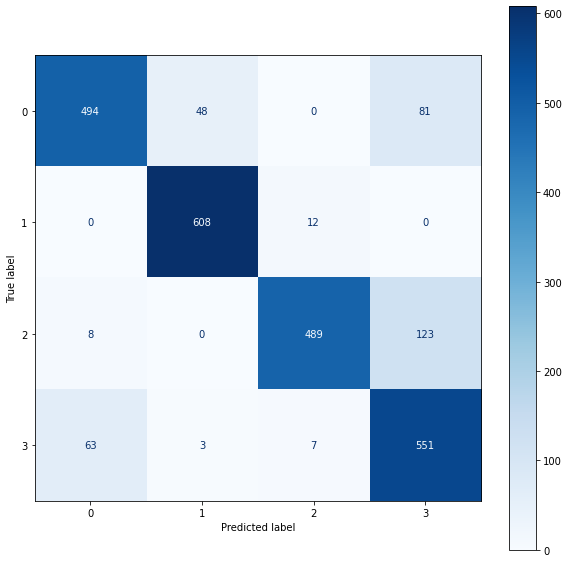

In [ ]:
#Comute predictions and the label with the maximum probability
labels_test, probs = get_predictions(model_ft, test_loader, device)
pred_labels_test = torch.argmax(probs, 1)
plot_confusion_matrix(labels_test, pred_labels_test)

## Predicciones fine tuning (model_ft_aug)

Test acc: 0.8585


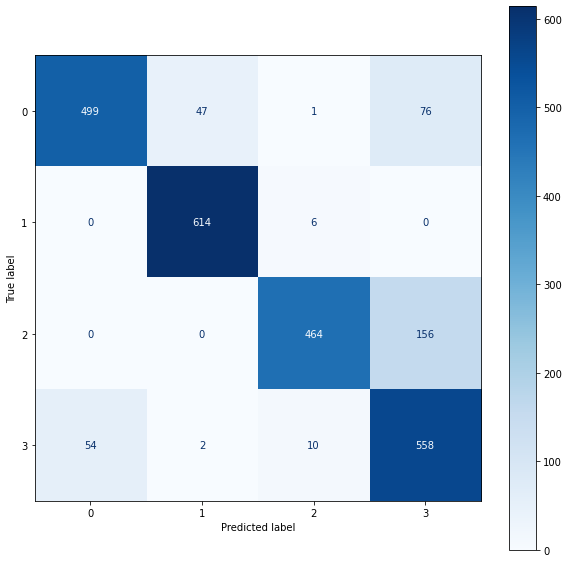

In [ ]:
#Comute predictions and the label with the maximum probability
labels_test, probs = get_predictions(model_ft_aug, test_loader, device)
pred_labels_test = torch.argmax(probs, 1)
plot_confusion_matrix(labels_test, pred_labels_test)

## Predicciones freeze (model_fz)

Test acc: 0.6051


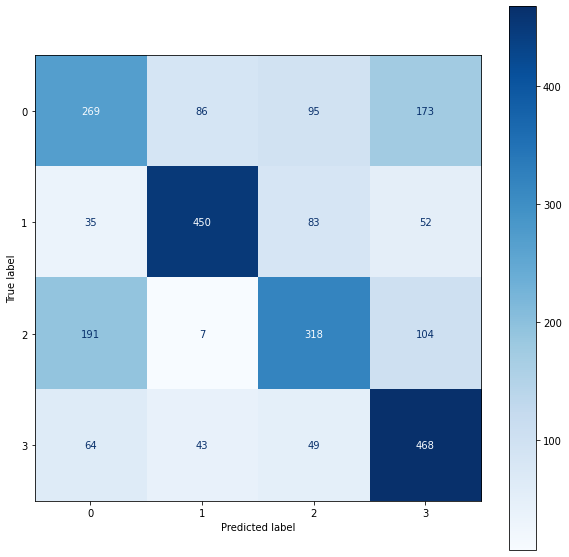

In [ ]:
labels, probs = get_predictions(model_fz, test_loader, device)
pred_labels = torch.argmax(probs, 1)
plot_confusion_matrix(labels, pred_labels)

## Predicciones model_ft_adam

Test acc: 0.8561


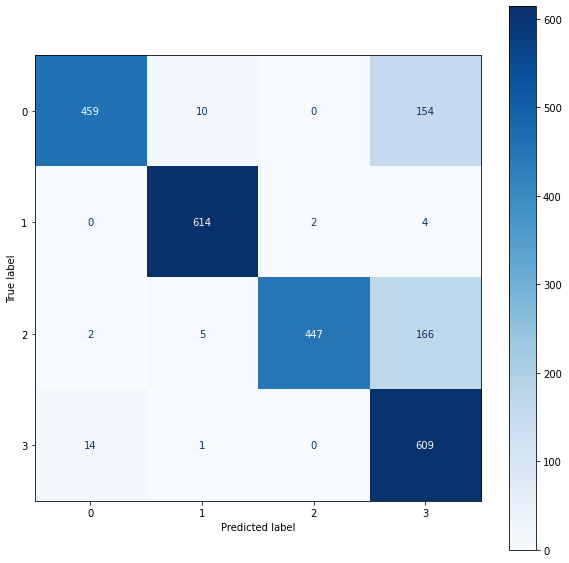

In [ ]:
labels, probs = get_predictions(model_ft_adam, test_loader, device)
pred_labels = torch.argmax(probs, 1)
plot_confusion_matrix(labels, pred_labels)

## Predicciones model_ft_adam_aug

Test acc: 0.8408


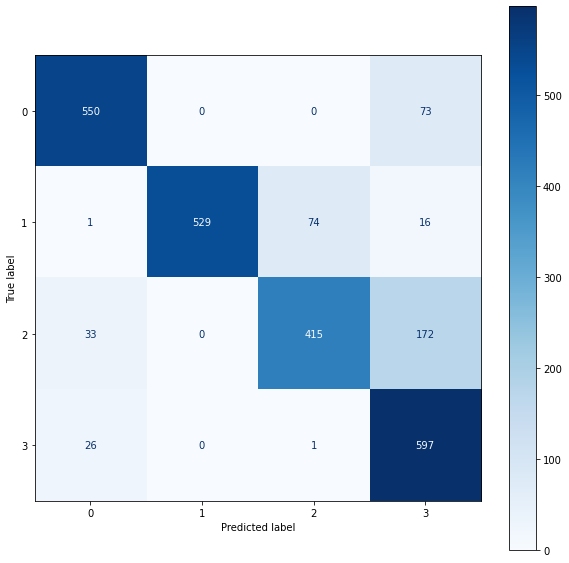

In [ ]:
labels, probs = get_predictions(model_ft_adam_aug, test_loader, device)
pred_labels = torch.argmax(probs, 1)
plot_confusion_matrix(labels, pred_labels)

## Predicciones model_ft34

Test acc: 0.8605


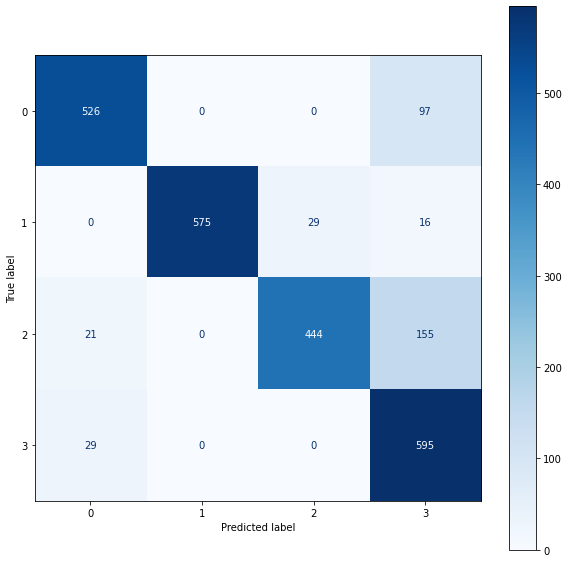

In [ ]:
labels, probs = get_predictions(model_ft34, test_loader, device)
pred_labels = torch.argmax(probs, 1)
plot_confusion_matrix(labels, pred_labels)

## Predicciones model1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Test acc: 0.6916


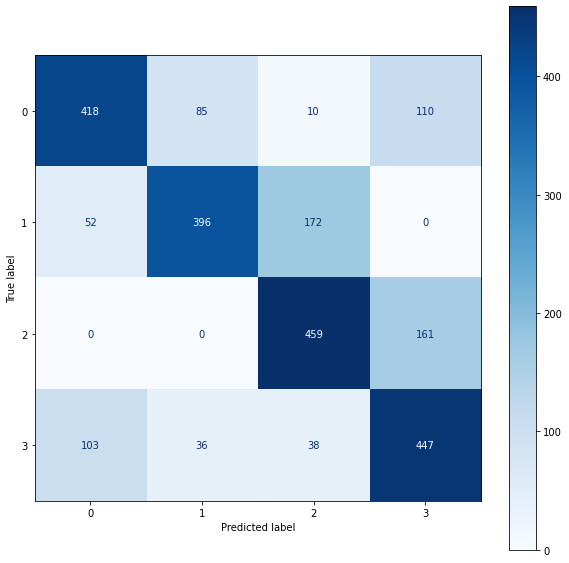

In [ ]:
labels, probs = get_predictions(model1, test_loader, device)
pred_labels = torch.argmax(probs, 1)
plot_confusion_matrix(labels, pred_labels)

## Predicciones model2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Test acc: 0.7282


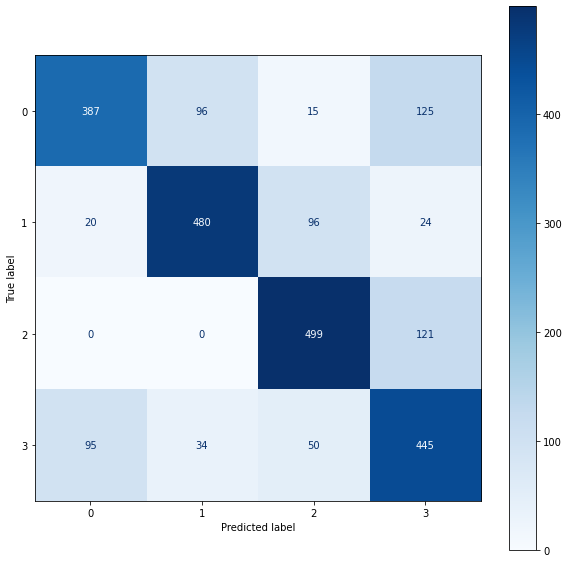

In [ ]:
labels, probs = get_predictions(model2, test_loader, device)
pred_labels = torch.argmax(probs, 1)
plot_confusion_matrix(labels, pred_labels)

## Predicciones model3

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Test acc: 0.8500


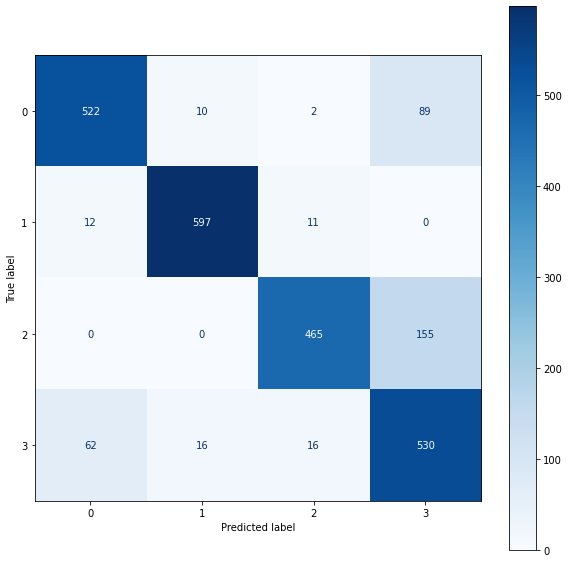

In [ ]:
labels, probs = get_predictions(model3, test_loader, device)
pred_labels = torch.argmax(probs, 1)
plot_confusion_matrix(labels, pred_labels)

##Accuracy para de los diferentes modelos




| Modelo | Accuracy de train | Accuracy de val | Accuracy de test | 
| --- | --- | --- | --- | 
| Resnet18 con Fine Tuning | 0.7280 | 0.8873 | 0.8613 | 
| Resnet18 con Freeze | 0.5802 |  0.7183 | 0.6051 |
| Resnet18 Data Aumentation | 0.8293 | 0.9014 | 0.8585 |
| Resnet18 Adam | 0.8635 | 0.9155 | 0.8561 |
| Resnet18 con Adam y Data Aumentation | 0.9556 | 0.9155 | 0.8408 |
| Resnet34 con Fine Tuning | 0.9507 | 0.9296 | 0.8605 | 
| Redes creadas desde 0 - Modelo 1 | 0.7372 | 0.7324 | 0.6916 | 
| Redes creadas desde 0 - Modelo 2 | 0.6418 | 0.7324 | 0.7282 |
| Redes creadas desde 0 - Modelo 2 con Adam | 0.7778 | 0.8451 | 0.8500 |

# Conclusiones

Tras comparar diferentes redes de aprendizaje por transfer learning y redes creadas nosotros mismos, podemos determinar cuál parece ser la más eficaz.

* Freeze transfer learning: Freeze consiste en congelar los parámetros de las capas convolucionales, esto  impide que se modifiquen los pesos de las capas convolucionales. Freeze es útil, cuando la data que se quiere clasificar, es similar a la data que se usó para entrenar la red, por lo tanto el bajo accuracy indica que las imágenes que se desea clasificar tienen poca similitud con la data de entrenamiento de ResNet18 y por tanto, no es un buen modelo.

* El modelo 2 se compone de una capa convolucional mas quel modelo 1 que hemos creido desde 0. Este capa mas permite aumentar de manera sinificativa el accuracy de train como se ve en los resultados. 

* El modelo 3 se trata de usar la misma capa convolucional quel modelo 2 pero usando la funcion Adam como algoritmo de optimización. Observamos que obtenemos un accuracy de train un poco mejor quel modelo 2. 
En la literatura, encontramos muchos estudios describiendo la cosa siguiente para clasificacion de imagen :
Adam puede tener un buen accuracy de train pero un mal accuracy de test (y con el dataset val) si la comparamos con SGD. Eso se expliqua porque Adam encuentra soluciones que generalizan peor que las encontradas por SGD. Incluso cuando Adam consigue una pérdida de entrenamiento igual o inferior a la de SGD, el rendimiento en el dataset de test es peor.

* El modelo_ft_adam usa resnet18 con data aumentation y el algoritmo de optimizacion Adam. Si bien se esperaba que con data augmentation el overfitting disminuiría, esto en general no sucedió (en casi ninguno de los modelos con augmentation), esto se explica debido a que la función RandomResizedCrop ya aporta con la suficiente variabilidad a la data de entrenamiento, es por esto que el primer modelo (fine tuning sin augmentation) no posee overfitting. Es por esto que para los últimos dos modelos no se usó augmentation.

* Para el modelo con Resnet34, si bien el accuracy de train aumentó, esto no sucedió con el accuracy de test en comparación a Resnet18.

Para concluir, no logramos ha encontrar un modelo mas eficiente que sea en tiempo de computo así como en accuracy de train/test que el Resnet18, que nos parece despues de varios experimentaciones uno de los mejores modelo para clasificar estas celulas sanguineas en aspectos de tiempo de cómputo, rapidez (en épocas) para converger, overfitting y accuracy. 

Si bien con el último modelo no se alcanzó el mejor accuracy de test, también puede considerarse como un buen modelo, esto pues alcanzó accuracys comparables con resnet18 con menos parámetros, y por tanto, con menos tiempo total de ejecución.
